In [151]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS, Transformer
from matplotlib.colors import Normalize, ListedColormap
from shapely.geometry import Point

def set_plot_limits(ax, lon_min, lon_max, lat_min, lat_max):
    # Transformer for converting between WGS84 and Web Mercator
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
    # Transform input coordinates to Web Mercator
    x_min, y_min = transformer.transform(lat_min, lon_min)
    x_max, y_max = transformer.transform(lat_max, lon_max)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

def findControlPoint(gdf_mercator, element, opts):
    # Create a GeoDataFrame with control point
    control_point = gpd.GeoDataFrame(geometry=[Point(opts['control_lon'], opts['control_lat'])], crs='EPSG:4326').to_crs(epsg=3857)
    # Calculate distance to control point
    gdf_mercator['distance_to_control'] = gdf_mercator.geometry.distance(control_point.geometry[0])

    # Subset to points within max distance
    least_contaminated = gdf_mercator.loc[gdf_mercator['distance_to_control'] <= opts['max_distance']]
    control_x, control_y, control_concentration = (
        least_contaminated['x'].mean(),
        least_contaminated['y'].mean(),
        least_contaminated[element].mean()
    )
    return control_x, control_y, control_concentration

def add_text_box(ax,control_gdf):
    # Create a transformer for the coordinate conversion
    transformer_mercator_to_latlon = Transformer.from_crs("epsg:3857", "epsg:4326")

    # Convert Mercator meters to degrees north and east
    lon, lat = transformer_mercator_to_latlon.transform(control_gdf.geometry.x.values[0], control_gdf.geometry.y.values[0])

    # Add text box for control point concentration and location
    control_point_text = f"Control Point:\nConcentration: {control_gdf['control_concentration'][0]:.1f} ppm\nLocation: ({lon:.2f}, {lat:.2f})"
    ax.text(0.02, 0.98, control_point_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


def process_file(file_name, element, opts):
    df = pd.read_csv(file_name, na_values='< LOD')
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=3857) # Convert coordinate reference system
    gdf = gdf.dropna(subset=[element])

    if opts['control_point']:
        if 'control_concentration' not in opts:
            control_x, control_y, control_concentration = findControlPoint(gdf, element, opts)
            control_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([control_x], [control_y]), crs='EPSG:4326').to_crs(epsg=3857)
            control_gdf['control_concentration'] = control_concentration
        else:
            control_x, control_y, control_concentration = opts['control_lon'], opts['control_lat'], opts['control_concentration']
            control_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([control_x], [control_y]), crs='EPSG:4326').to_crs(epsg=3857)
            control_gdf['control_concentration'] = control_concentration
    else:
        control_x, control_y, control_concentration = 0, 0, 0
        control_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([control_x], [control_y]), crs='EPSG:4326').to_crs(epsg=3857)
        control_gdf['control_concentration'] = control_concentration

    # now remove points in a gdf that is focussed on a specific area: gdf_filt
    df = df[
        (df['y'] <= opts['ignore_lat_max']) &
        (df['y'] >= opts['ignore_lat_min']) &
        (df['x'] <= opts['ignore_lon_max']) &
        (df['x'] >= opts['ignore_lon_min'])
    ]
    gdf_filt = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs='EPSG:4326')
    gdf_filt = gdf_filt.to_crs(epsg=3857) # Convert coordinate reference system
    gdf_filt = gdf_filt.dropna(subset=[element])
    gdf_filt['element_deltaX'] = gdf_filt[element]-control_concentration

    return gdf, gdf_filt, control_gdf

def add_inset_map2(ax,opts, gdf, gdf_filt):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cmap = ListedColormap([plt.cm.viridis(i / 10) for i in range(10)])
    transformer_inset = Transformer.from_crs('EPSG:4326', 'EPSG:3857')
    iax = inset_axes(ax, width="35%", height="35%", loc=1,
                     bbox_to_anchor=(opts['map2_posX'], opts['map2_posY'], 1.8, 1.6),
                     bbox_transform=ax.transAxes, borderpad=0.2)
    

    inset_xmin, inset_ymin = transformer_inset.transform(opts['map2_lat1'],opts['map2_lon1'])
    inset_xmax, inset_ymax = transformer_inset.transform(opts['map2_lat2'],opts['map2_lon2'])
    iax.set_xlim(min(inset_xmin, inset_xmax), max(inset_xmin, inset_xmax))
    iax.set_ylim(min(inset_ymin, inset_ymax), max(inset_ymin, inset_ymax))

    
    print(gdf_filt['Name'])
    # Sort GeoDataFrame based on normalized contamination
    scatter = iax.scatter(gdf_filt.geometry.x, gdf_filt.geometry.y, c=gdf_filt["normalized_contamination"], cmap=cmap, s=50)
    for x, y, label in zip(gdf_filt.geometry.x, gdf_filt.geometry.y, gdf_filt['Name']):
        iax.text(x, y, label, fontsize=8)
    
    ctx.add_basemap(iax, source=ctx.providers.OpenTopoMap, zoom=15, attribution_size=0)
    iax.set_xticks([]), iax.set_yticks([])
    return iax


def add_inset_map(ax, opts, gdf, control_gdf):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    transformer_inset = Transformer.from_crs('EPSG:4326', 'EPSG:3857')
    iax = inset_axes(ax, width="35%", height="35%", loc=1,
                     bbox_to_anchor=(opts['map1_posX'], opts['map1_posY'],1.6, 1.2), bbox_transform=ax.transAxes, borderpad=0.2)

    inset_xmin, inset_ymin = transformer_inset.transform(opts['map1_lat1'],opts['map1_lon1'])
    inset_xmax, inset_ymax = transformer_inset.transform(opts['map1_lat2'],opts['map1_lon2'])
    iax.set_xlim(min(inset_xmin, inset_xmax), max(inset_xmin, inset_xmax))
    iax.set_ylim(min(inset_ymin, inset_ymax), max(inset_ymin, inset_ymax))

    iax.scatter(gdf.geometry.x, gdf.geometry.y, color='black', s=20)
    iax.scatter(control_gdf.geometry.x, control_gdf.geometry.y, color='blue', s=20)

    ctx.add_basemap(iax, source=ctx.providers.OpenTopoMap, zoom=11, attribution_size=0)
    main_xmin, main_xmax =  ax.get_xlim()
    main_ymin, main_ymax =  ax.get_ylim()
    iax.plot([main_xmin, main_xmin, main_xmax, main_xmax, main_xmin],
             [main_ymin, main_ymax, main_ymax, main_ymin, main_ymin],
             color='red', linewidth=1.5, linestyle='-')
    iax.set_xticks([]), iax.set_yticks([])


def plot_contamination_map(file_name, element, opts):
    gdf, gdf_filt, control_gdf = process_file(file_name, element, opts)

    cmap = ListedColormap([plt.cm.coolwarm(i / 10) for i in range(10)])
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.set_facecolor('white')

    gdf_filt["normalized_contamination"] = Normalize()(gdf_filt['element_deltaX'])
    gdf_filt = gdf_filt.sort_values(by="normalized_contamination")
    
    # Calculate percentiles for the colorbar limits
    vmin, vmax = np.percentile(gdf_filt['element_deltaX'], [10, 90])
    
    # Define normalization
    from matplotlib.colors import TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the points with color based on relative contamination
    scatter = ax.scatter(gdf_filt.geometry.x, gdf_filt.geometry.y, c=gdf_filt["element_deltaX"],
                         cmap=cmap, norm=norm, s=100)

    #print(gdf_filt)
    #for x, y, label in zip(gdf_filt.geometry.x, gdf_filt.geometry.y, gdf_filt['name']):
    #    ax.text(x, y, label, fontsize=8)
    
    set_plot_limits(ax, opts['map_lon_min'], opts['map_lon_max'], opts['map_lat_min'], opts['map_lat_max'])

    # Plot the base map
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

     
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.4)
    colorbar.set_label(f'Difference in {element} Concentration Relative to Control Point (ppm)')

    # Generate tick values
    # Check if 0 is in range
    if vmin <= 0 <= vmax:
        # Generate 4 ticks for the negative and positive ranges each
        negative_ticks = np.linspace(vmin, 0, num=5)
        positive_ticks = np.linspace(0, vmax, num=5)

        # Concatenate the two arrays, excluding one of the zeros
        ticks = np.concatenate((negative_ticks[:-1], positive_ticks))
    else:
        # If 0 is not in range, just use the linspace between vmin and vmax
        ticks = np.linspace(vmin, vmax, num=5)

    colorbar.set_ticks(ticks)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xticks = np.linspace(xmin, xmax, num=5)
    yticks = np.linspace(ymin, ymax, num=5)
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    xticklabels = [round(transformer.transform(x, ymin)[1], 4) for x in xticks]
    yticklabels = [round(transformer.transform(xmin, y)[0], 4) for y in yticks]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add text box for control point concentration and location
    add_text_box(ax,control_gdf)

    plt.title(opts['plot_title'])

    #add_inset_map(ax,opts,gdf,control_gdf) # Add inset map
    #iax=add_inset_map2(ax,opts,gdf,gdf_filt) # Add inset map
    #main_xmin, main_xmax =  iax.get_xlim()
    #main_ymin, main_ymax =  iax.get_ylim()

    #ax.plot([main_xmin, main_xmin, main_xmax, main_xmax, main_xmin],
    #         [main_ymin, main_ymax, main_ymax, main_ymin, main_ymin],
    #         color='red', linewidth=1.5, linestyle='-')
    
    plt.savefig(f"{opts['plot_dir']}contamination_map_{element}.png", dpi=300)


/Users/research/Venvs/GISpackages/venv/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)
/Users/research/Venvs/GISpackages/venv/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)
/Users/research/Venvs/GISpackages/venv/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)
/Users/research/Venvs/GISpackages/venv/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)
/Users/research/Venvs/GISpackages/venv/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inf

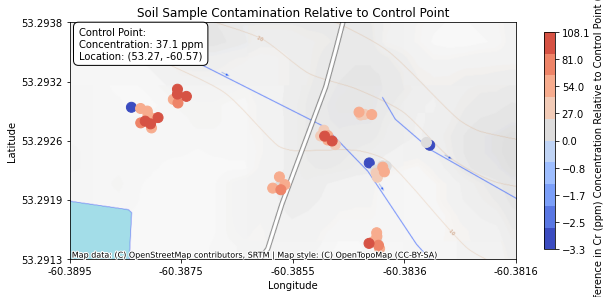

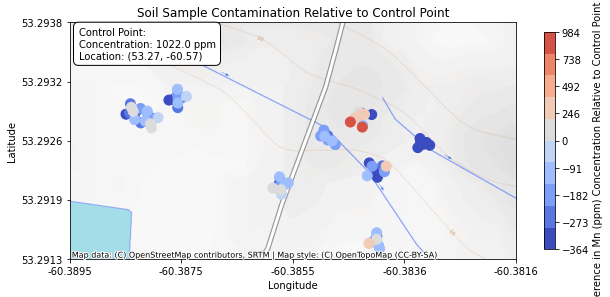

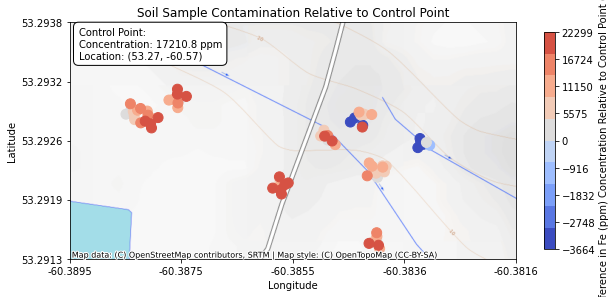

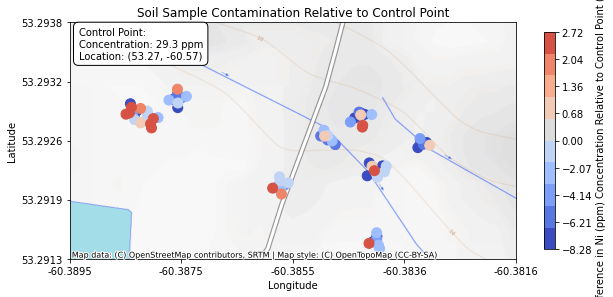

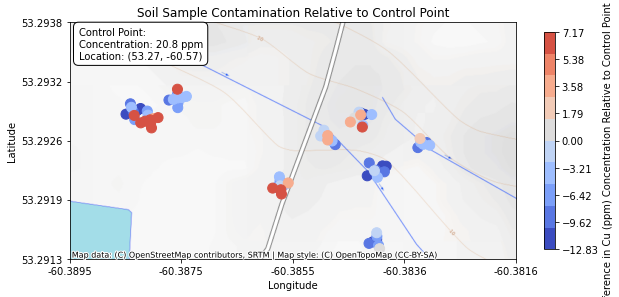

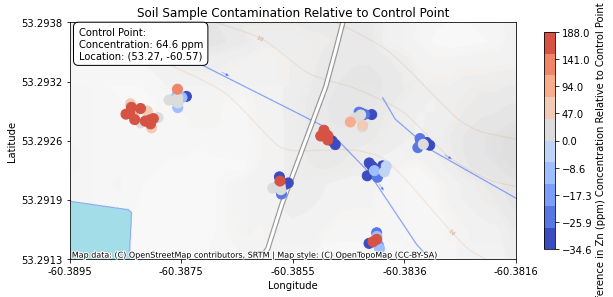

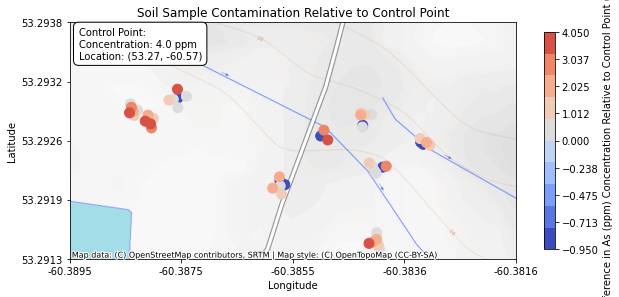

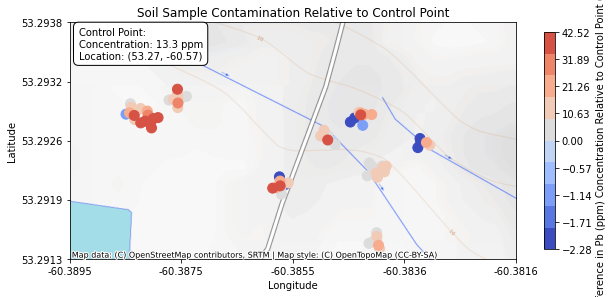

In [152]:
opts = {
    #'plot_dir': './tree_plots/',
    'plot_dir': './soil_plots/',
    'plot_title': 'Soil Sample Contamination Relative to Control Point',
    #'plot_title': 'Tree Core Contamination Relative to Control Point',
    #'control_concentration': 0,
    'control_point': True,
    'max_distance': 200, # the max distance to consider for cluster control point cluster
    'control_lon':  -60.574290,
    'control_lat':  53.268397,
    #'map_lon_min': -60.445, # map plot limits to keep plots consistent
    #'map_lon_max': -60.3675,
    #'map_lat_min': 53.267,
    #'map_lat_max': 53.32,
    'ignore_lat_min': 53.267, # data limits to consider
    'ignore_lat_max': 53.32,
    'ignore_lon_min': -60.445,
    'ignore_lon_max': -60.36,   
    # Map 1 - limits
    'map1_lat1': 53.25 , 
    'map1_lon1':-60.595,
    'map1_lat2': 53.404,
    'map1_lon2': -60.30,
    'map1_posX': -0.487 ,
    'map1_posY': -0.2,
    # Map 2 - ignored
    'map2_lat1': 53.2893, 
    'map2_lon1':-60.40  ,
    'map2_lat2': 53.298 ,
    'map2_lon2': -60.379,
    'map2_posX': -1.15  ,
    'map2_posY': -1.06  ,
    'map_lon_min': -60.3895, # map plot limits to keep plots consistent
    'map_lon_max': -60.3816,
    'map_lat_min': 53.2913,
    'map_lat_max': 53.2938,
}
#filename = 'tree_core_samples_avg.csv'
filename = 'soil_samples.csv'
elements = ['Cr (ppm)','Mn (ppm)','Fe (ppm)','Ni (ppm)','Cu (ppm)','Zn (ppm)','As (ppm)','Pb (ppm)']
for element in elements:
    plot_contamination_map(filename,element,opts)